<h1>Прогнозирование заказов такси<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Upload-and-data-preparation" data-toc-modified-id="Upload-and-data-preparation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Upload and data preparation</a></span><ul class="toc-item"><li><span><a href="#Conclusion-on-data-uploading" data-toc-modified-id="Conclusion-on-data-uploading-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Conclusion on data uploading</a></span></li></ul></li><li><span><a href="#Data-analysis" data-toc-modified-id="Data-analysis-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Data analysis</a></span><ul class="toc-item"><li><span><a href="#Extended-Dickey-Fuller-test" data-toc-modified-id="Extended-Dickey-Fuller-test-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Extended Dickey-Fuller test</a></span></li><li><span><a href="#Series-decomposition" data-toc-modified-id="Series-decomposition-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Series decomposition</a></span></li><li><span><a href="#Conclusion-from-data-analysis" data-toc-modified-id="Conclusion-from-data-analysis-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Conclusion from data analysis</a></span></li></ul></li><li><span><a href="#Models-learning" data-toc-modified-id="Models-learning-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Models learning</a></span><ul class="toc-item"><li><span><a href="#Features-creation" data-toc-modified-id="Features-creation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Features creation</a></span></li><li><span><a href="#Model-CatBoostRegressor" data-toc-modified-id="Model-CatBoostRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Model CatBoostRegressor</a></span></li><li><span><a href="#Model-Lasso" data-toc-modified-id="Model-Lasso-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Model Lasso</a></span></li><li><span><a href="#Model-LGBMRegressor" data-toc-modified-id="Model-LGBMRegressor-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Model LGBMRegressor</a></span></li><li><span><a href="#Conclusion-on-model-learning" data-toc-modified-id="Conclusion-on-model-learning-3.5"><span class="toc-item-num">3.5&nbsp;&nbsp;</span>Conclusion on model learning</a></span></li></ul></li><li><span><a href="#Test-of-best-model" data-toc-modified-id="Test-of-best-model-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Test of best model</a></span></li><li><span><a href="#Predictions-of-best-model-for-next-period" data-toc-modified-id="Predictions-of-best-model-for-next-period-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Predictions of best model for next period</a></span></li><li><span><a href="#General-conclusion" data-toc-modified-id="General-conclusion-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>General conclusion</a></span></li></ul></div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

import warnings
warnings.simplefilter("ignore")

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from scipy import stats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error
    )

from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

sns.set(rc={'figure.figsize':(15, 6)})

In [26]:
RANDOM_STATE = 41
TEST_SIZE = 0.1

## Upload and data preparation

In [2]:
file_local = '/Users/alexfil/Desktop/Practicum/Проекты/Временные ряды/taxi.csv'
file_ya = 'https://code.s3.yandex.net/datasets/taxi.csv'

In [3]:
try:
    df = pd.read_csv(file_local, index_col=[0], parse_dates=[0]) 
except:
    df = pd.read_csv(file_ya, index_col=[0], parse_dates=[0])

In [4]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
df.sort_index(inplace=True)

In [7]:
df.index.is_monotonic_increasing

True

In [8]:
df = df.resample('1H').sum()
df.dropna(inplace=True)
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [9]:
df.shape

(4416, 1)

### Conclusion on data uploading

1. Dataset with a size of 26,496 lines was uploaded, no gaps were detected. When loading, the date column is used as an index.
2. Data is arranged in chronological ascending order.
3. Resampling was done one hour at a time. The new dataset contains 4,416 rows

## Data analysis

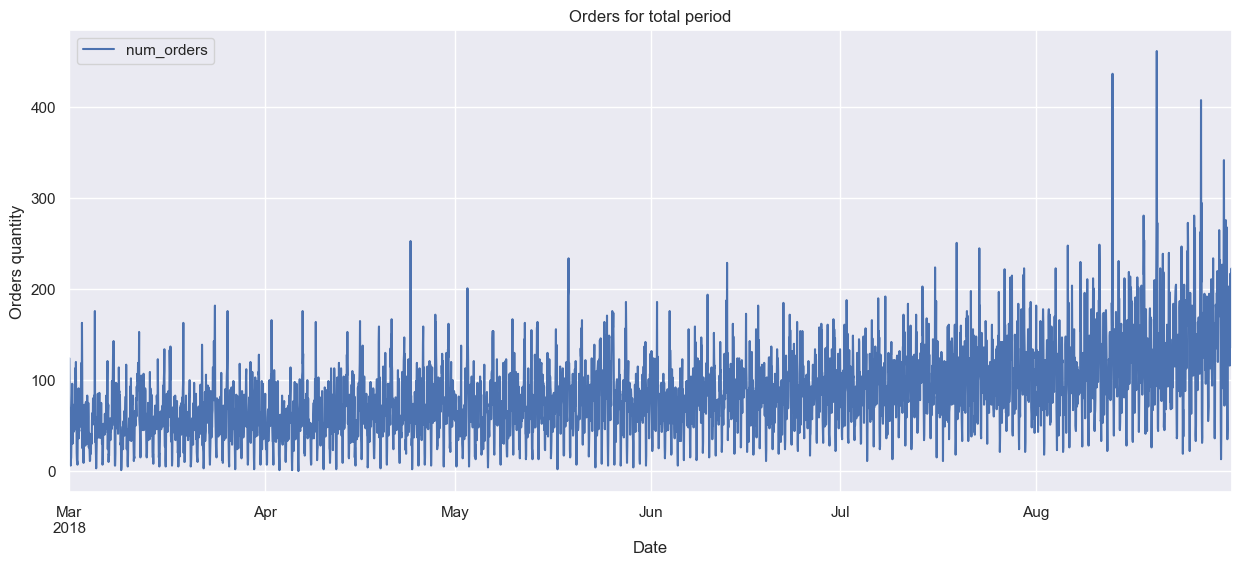

Average till June: 65.18055555555556
Average after June: 103.84239130434783


In [10]:
df.plot()
plt.title('Orders for total period')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
plt.show()

print(f'Average till June: {df[: "2018-06-01"]["num_orders"].mean()}')
print(f'Average after June: {df["2018-06-01":]["num_orders"].mean()}')

### Extended Dickey-Fuller test

In [11]:
adfuller(df)

(-3.0689242890279593,
 0.02894005140261262,
 30,
 4385,
 {'1%': -3.431842162413052,
  '5%': -2.8621993540813637,
  '10%': -2.567120978470452},
 41728.71357827463)

Tsts statistic: -3,06892

p-value: 0,029

p-value is less than the significance level of 0.05, then we can reject the null hypothesis about the non-stationarity of the series and consider this series to be stationary.

### Series decomposition

In [12]:
decomposed = seasonal_decompose(df)

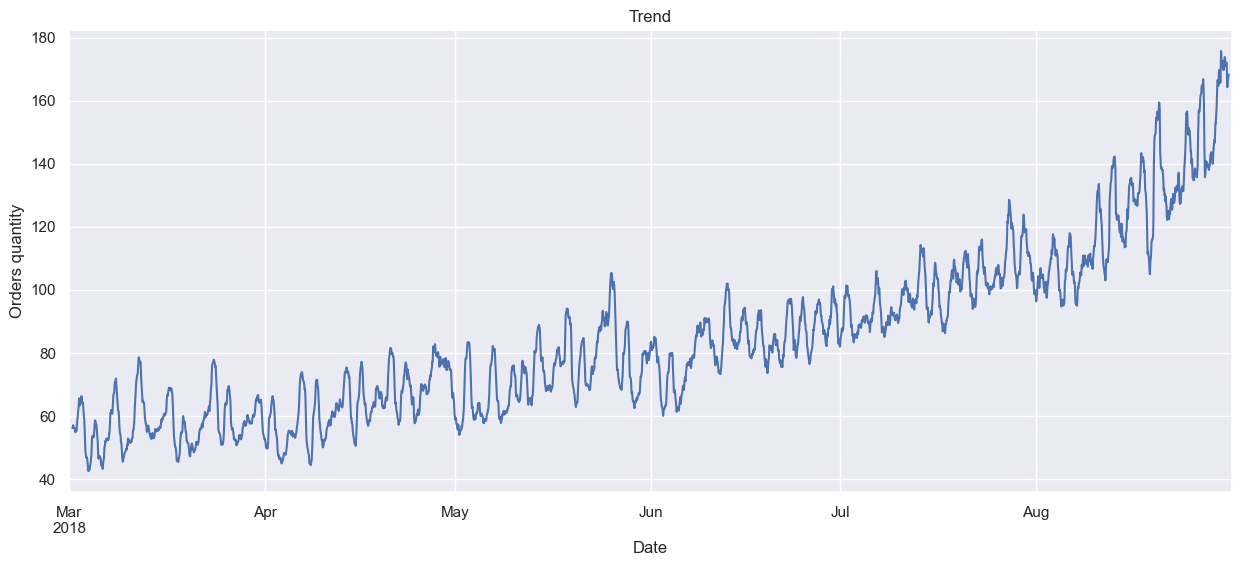

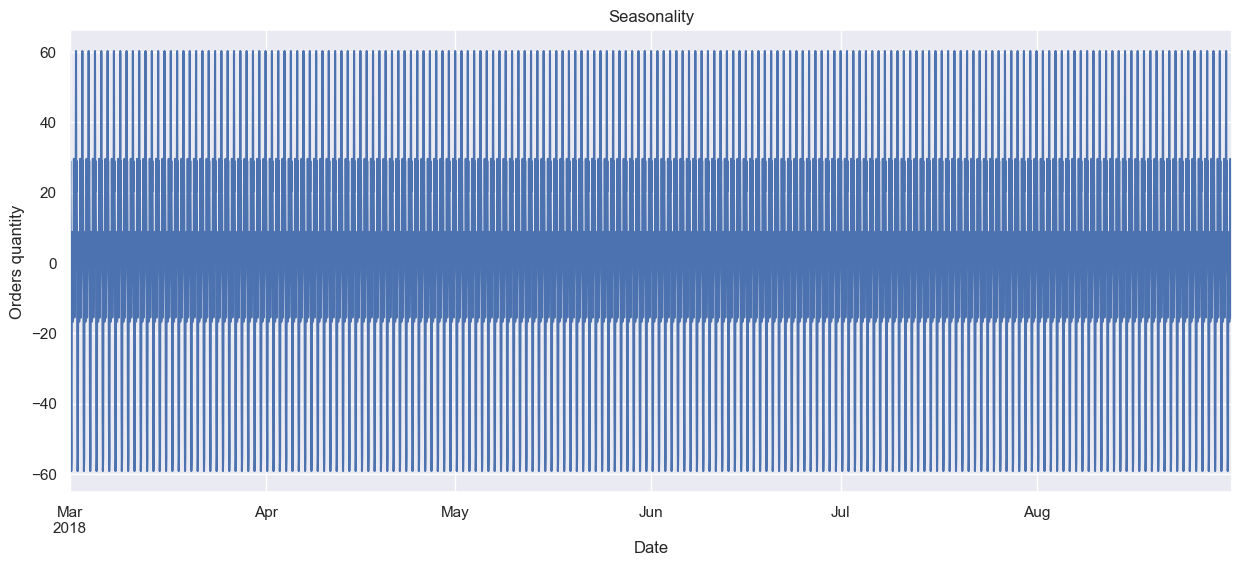

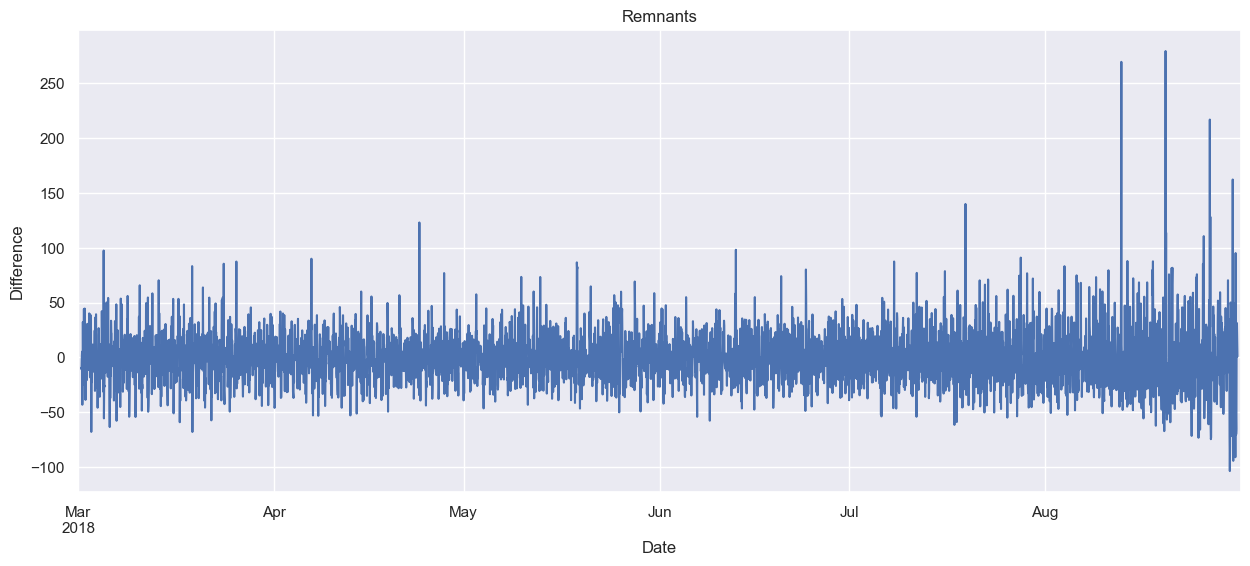

In [13]:
decomposed.trend.plot(ax = plt.gca())
plt.title('Trend')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
plt.show()

decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
plt.show()

decomposed.resid.plot(ax = plt.gca())
plt.title('Remnants')
plt.xlabel('Date')
plt.ylabel('Difference')
plt.show()

The trend graph shows an increase in the number of orders since June, as the holiday season begins and the number of flights and air ticket sales increases

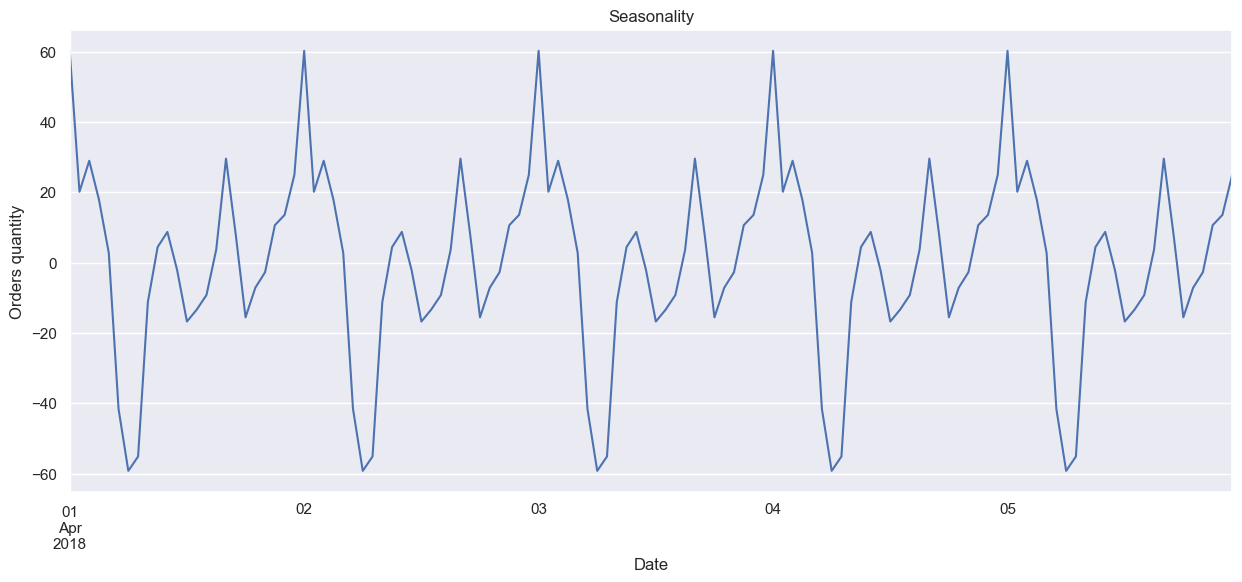

In [14]:
decomposed.seasonal['2018-04-01':'2018-04-05'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
pass

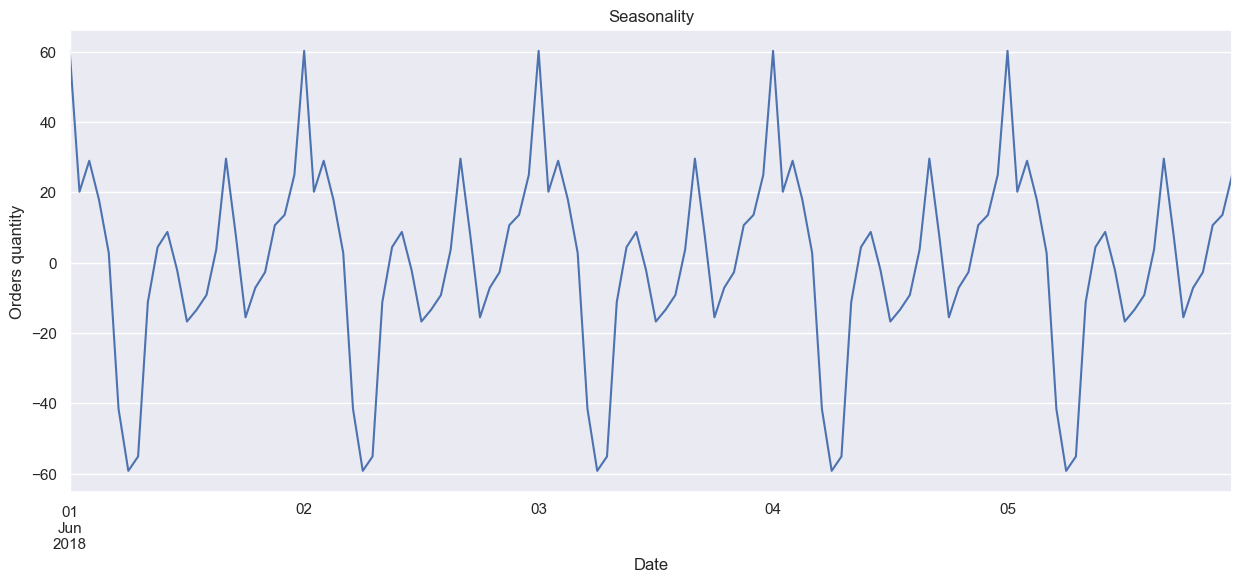

In [15]:
decomposed.seasonal['2018-06-01':'2018-06-05'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
pass

From the graphs we see that seasonality consists of fluctuations with a period of one day

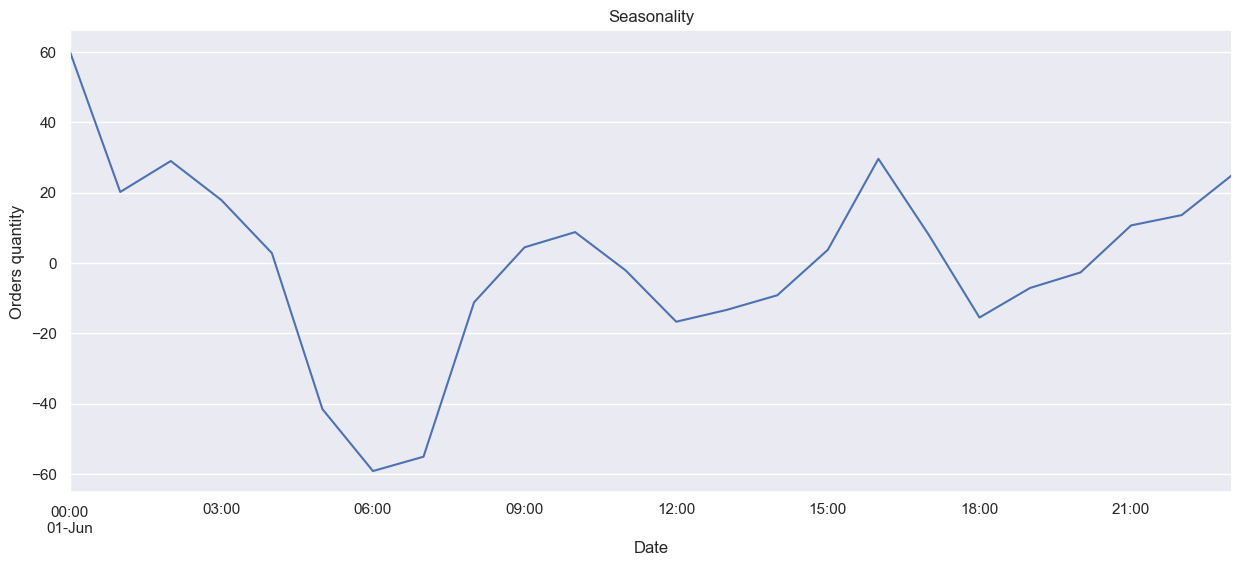

In [16]:
decomposed.seasonal['2018-06-01'].plot(ax = plt.gca())
plt.title('Seasonality')
plt.xlabel('Date')
plt.ylabel('Orders quantity')
pass

- peak orders around 12 midnight;

- minimum orders at 6 am;

- there is a local maximum around 17.00, after which there is an increase until 24.00

These observations can be explained since the peak arrival and departure times of flights are in three hour intervals: morning from 9.00, afternoon from 15.00 and late evening from 21.00

Also, according to the residual graph, we can observe noise bursts in the second half of August that are associated with the trend

In [17]:
df_aug = df['2018-08-01':]
df_aug['rolling_mean'] = df_aug.shift().rolling(5).mean()

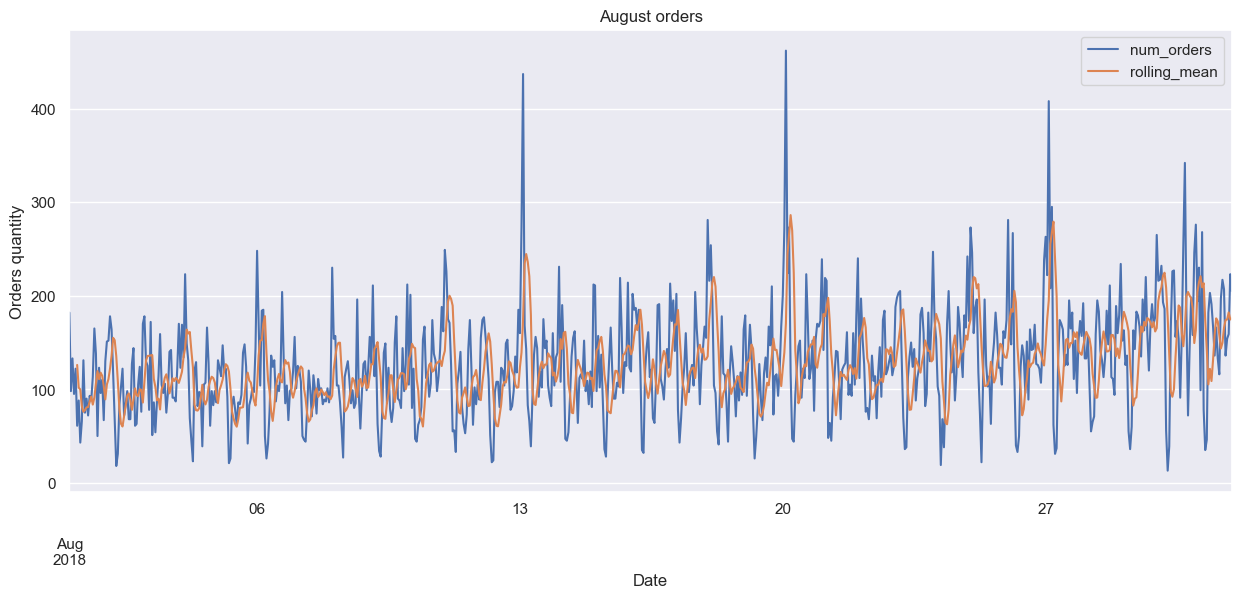

In [18]:
df_aug.plot()
plt.title('August orders');
plt.xlabel('Date')
plt.ylabel('Orders quantity')
pass

The graph shows that on August 13, 20 and 27 there are peaks in the number of orders; these days were Mondays

### Conclusion from data analysis

1. The trend graph shows an increase in the number of orders since June, as the holiday season begins and the number of flights and air ticket sales increases

2. According to the extended Dickey-Fuller test:

- Test statistics: -3.06892

- p-value: 0.029

The p-value is less than the significance level of 0.05, then we can reject the null hypothesis about the non-stationarity of the series and consider this series to be stationary.

3. From the graphs we see that seasonality consists of fluctuations with a period of one day

- peak orders around 12 midnight;

- minimum orders at 6 am;

- there is a local maximum around 17.00, after which there is an increase until 24.00

These observations can be explained since the peak arrival and departure times of flights are in three hour intervals: morning from 9.00, afternoon from 15.00 and late evening from 21.00

Also, according to the residual graph, we can observe noise bursts in the second half of August that are associated with the trend

4. The August graph shows that on August 13, 20 and 27 there are peaks in the number of orders; these days were Mondays

## Models learning

### Features creation

In [21]:
def make_features(data, max_lag, rolling_mean_size):
    data_new = data.copy()
    data_new['hour'] = data_new.index.hour
    data_new['dayofweek'] = data_new.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        col = 'lag_' + str(lag)
        data_new[col] = data_new['num_orders'].shift(lag)
    
    data_new['rolling_mean'] = data_new['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data_new.dropna()

In [22]:
new_df = make_features(df, 24, 24)

In [23]:
new_df.head(5)

,num_orders,hour,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,...,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,0,4,58.0,113.0,66.0,61.0,45.0,73.0,44.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,56.833333
2018-03-02 01:00:00,120,1,4,90.0,58.0,113.0,66.0,61.0,45.0,73.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,55.416667
2018-03-02 02:00:00,75,2,4,120.0,90.0,58.0,113.0,66.0,61.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,56.875000
2018-03-02 03:00:00,64,3,4,75.0,120.0,90.0,58.0,113.0,66.0,61.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,57.041667
2018-03-02 04:00:00,20,4,4,64.0,75.0,120.0,90.0,58.0,113.0,66.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,56.958333


In [24]:
new_df.shape

(4392, 28)

In [27]:
X = new_df.drop('num_orders', axis = 1)
y = new_df['num_orders']
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    shuffle=False,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
    )

### Model CatBoostRegressor

In [28]:
param_grid_cat = {
    'depth': [3, 5, 7],
    'learning_rate': [0.1, 0.3, 0.5, 0.7]
}

In [29]:
model_cat = CatBoostRegressor(iterations=100,
                              l2_leaf_reg = 0.5,
                              verbose=False,
                              random_state = RANDOM_STATE)

In [30]:
tscv = TimeSeriesSplit(n_splits=5) #разделение временного ряда на 5 частей

In [31]:
grid_search_cat = GridSearchCV(
    model_cat, 
    param_grid_cat, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
)
grid_search_cat.fit(X_train, y_train)

best_model_cat = grid_search_cat.best_estimator_


print('Best parameters:', grid_search_cat.best_params_)
print('Best RMSE on cross-validation:', -grid_search_cat.best_score_)

Best parameters: {'depth': 7, 'learning_rate': 0.1}
Best RMSE on cross-validation: 24.695571265028732


### Model Lasso

In [32]:
X_train.columns

Index(['hour', 'dayofweek', 'lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean'],
      dtype='object')

In [33]:
ord_columns = ['hour', 'dayofweek']
num_columns = ['lag_1', 'lag_2', 'lag_3', 'lag_4', 'lag_5',
       'lag_6', 'lag_7', 'lag_8', 'lag_9', 'lag_10', 'lag_11', 'lag_12',
       'lag_13', 'lag_14', 'lag_15', 'lag_16', 'lag_17', 'lag_18', 'lag_19',
       'lag_20', 'lag_21', 'lag_22', 'lag_23', 'lag_24', 'rolling_mean']

In [34]:
ord_pipe = Pipeline(
    [(
        'simpleImputer_before_ord',
        SimpleImputer(
            missing_values=np.nan,
            strategy='most_frequent'
        )
    ),
     (
         'ord',
         OrdinalEncoder(
                       handle_unknown='use_encoded_value',
                        
                        unknown_value=np.nan
            )
        ),
     (
         'simpleImputer_after_ord',
         SimpleImputer(
             missing_values=np.nan,
             strategy='most_frequent'
         )
     )
    ]
)

In [35]:
data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [36]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression()
    )
])

In [37]:
param_grid_las = [
    
    # словарь для модели LinearRegression()
    {
        'models': [Lasso(random_state=RANDOM_STATE)],
        'models__alpha': [0.1, 0.3, 0.5, 0.9, 1.0],
        'preprocessor__num': [StandardScaler(), 'passthrough']  
    }
]

In [38]:
grid_search_lasso = GridSearchCV(
    pipe_final, 
    param_grid_las, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
)

grid_search_lasso.fit(X_train, y_train)

best_model_lasso = grid_search_lasso.best_estimator_

print('Best parameters:', grid_search_lasso.best_params_)
print('Best RMSE on cross-validation:', -grid_search_lasso.best_score_)

Best parameters: {'models': Lasso(alpha=0.3, random_state=41), 'models__alpha': 0.3, 'preprocessor__num': StandardScaler()}
Best RMSE on cross-validation: 27.08026765930622


In [39]:
best_model_1 = grid_search_lasso.best_estimator_['models']

In [40]:
best_model_preprocessor_1 = grid_search_lasso.best_estimator_['preprocessor']

In [41]:
X_test_encoded = best_model_preprocessor_1.transform(X_test)

### Model LGBMRegressor

In [42]:
param_grid_lgbm = {
    'learning_rate': [0.1, 0.3, 0.5], 
    'num_leaves': [2, 3, 5, 7],
    'max_depth': [1, 2, 5, 8]
}

In [43]:
model_lgbm = LGBMRegressor(objective='root_mean_squared_error', 
                           verbose=-1, 
                           random_state=RANDOM_STATE
                          )

In [44]:
grid_search_lgbm = GridSearchCV(
    model_lgbm, 
    param_grid_lgbm, 
    cv=tscv, 
    scoring='neg_root_mean_squared_error'
    )

In [45]:
grid_search_lgbm.fit(X_train, y_train)
best_model_lgbm = grid_search_lgbm.best_estimator_

print('Best parameters:', grid_search_lgbm.best_params_)
print('Best RMSE on cross-validation:', -grid_search_lgbm.best_score_)

Best parameters: {'learning_rate': 0.1, 'max_depth': 8, 'num_leaves': 7}
Best RMSE on cross-validation: 24.73713984530735


### Conclusion on model learning

Best model on cross-validation is CatBoostRegressor.

RMSE on cross-validation is 24.69

## Test of best model

In [46]:
pred_cat = best_model_cat.predict(X_test)

print('LGBM RMSE on test data:', mean_squared_error(y_test, pred_cat, squared=False))

LGBM RMSE on test data: 42.68683603328066


RMSE metric of best model on test data is 42.68, what follow our task (no more than 48)

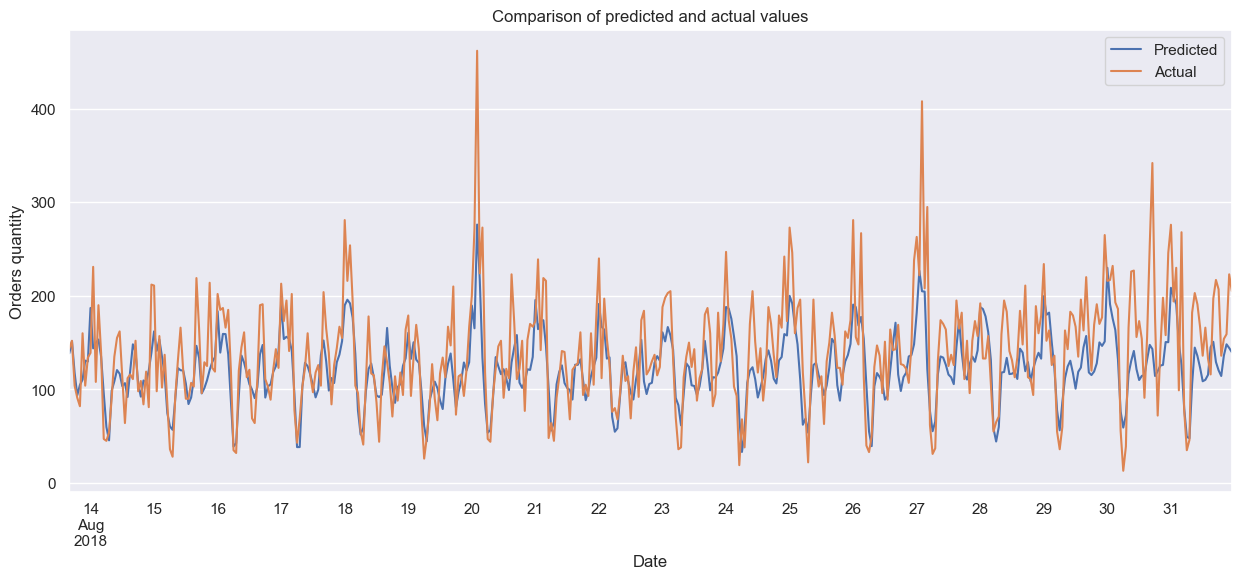

In [47]:
df_pred = pd.DataFrame(pred_cat, columns=['Predicted'])
df_actual = pd.DataFrame(y_test.values, columns=['Actual'])
df_check_pred = pd.concat([df_pred, df_actual], axis=1)
df_check_pred.index = y_test.index
df_check_pred.plot()
plt.title('Comparison of predicted and actual values')
plt.xlabel('Date')
plt.ylabel('Orders quantity');

## Predictions of best model for next period

In [66]:
n_periods = 1

In [68]:
def iterative_forecast(model, latest_data, n_periods):
    forecasts = []
    current_data = latest_data.copy()

    for _ in range(n_periods):
        # Создаем новые признаки
        features = make_features(current_data, 24, 24).iloc[-1:].drop('num_orders', axis=1)
        
        # Прогнозируем одно значение
        forecast = model.predict(features)[0]
        forecasts.append(forecast)
        
        # Добавляем прогноз как новое наблюдение в данные
        new_row = current_data.iloc[-1:].copy()
        new_row['num_orders'] = forecast
        current_data = pd.concat([current_data, new_row])
    
    return forecasts

# Выполняем итеративный прогноз
forecasts = iterative_forecast(best_model_cat, df, n_periods)
print(f'Prediction for {n_periods} periods ahead: {forecasts}')

Prediction for 1 periods ahead: [139.8390424542209]


## General conclusion

1. Dataset provided by the customer with size of 26,496 lines was uploaded, no gaps were detected. When uploading, the date column is used as an index.

2. Data is arranged in chronological ascending order.

3. Resampling was done one hour at a time. The new dataset contains 4,416 rows

4. The trend graph shows an increase in the number of orders since June, as the holiday season begins and the number of flights and air ticket sales increases

5. According to the extended Dickey-Fuller test:

- Test statistics: -3.06892

- p-value: 0.029

The p-value is less than the significance level of 0.05, then we can reject the null hypothesis about the non-stationarity of the series and consider this series to be stationary.

6. From the graphs we see that seasonality consists of fluctuations with a period of one day

- peak orders around 12 midnight;

- minimum orders at 6 am;

- there is a local maximum around 17.00, after which there is an increase until 24.00

These observations can be explained since the peak arrival and departure times of flights are in three hour intervals: morning from 9.00, afternoon from 15.00 and late evening from 21.00

Also, according to the residual graph, we can observe noise bursts in the second half of August that are associated with the trend

7. The August graph shows that on August 13, 20 and 27 there are peaks in the number of orders; these days were Mondays

8. The best tested model for cross-validation is CatBoostRegressor.

RMSE on cross-validation 24.69

9. RMSE metric of the best model on the test sample is 42.69, which corresponds to the conditions of the problem